# Install dependencies

In [1]:
#!pip install modAL

In [13]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling, uncertainty_sampling, margin_sampling
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import numpy as np
import random
from sklearn import metrics
from matplotlib import pyplot as plt
%matplotlib inline

# Load dataset

In [20]:
X, y = load_diabetes(return_X_y=True)
X.shape

(442, 10)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, train_size=0.5, random_state=42, shuffle=True)


N_QUERIES = 50

query_strategies = {
    'Uncertainty Sampling': uncertainty_sampling,
    'Margin Sampling': margin_sampling,
    'Entropy Sampling': entropy_sampling
}

for query_strategy_name, query_strategy in query_strategies.items():
    print('\n--- Using {} strategy ---'.format(query_strategy_name))
 
    classifiers = {
      'Random Forest Classifier': RandomForestClassifier(random_state=42),
      'Support Vector Classifier': SVC(probability=True, random_state=42),
      'Naive Bayes Classifier': GaussianNB()
    }

    for classifier_name, classifier in classifiers.items():
        learner = ActiveLearner(
            estimator=classifier,
            query_strategy=query_strategy,
            X_training=X_train, y_training=y_train
        )

        selected_samples = []
    
        for i in range(N_QUERIES):
            query_idx, query_instance = learner.query(X_train)
            selected_samples.append(query_idx[0])
            learner.teach(query_instance, y_train[query_idx])

        y_pred = learner.predict(X_test)
        confusion_matrix = metrics.confusion_matrix(y_test, y_pred).T

        #print('\nEvaluating {}'.format(classifier_name))
        #print(metrics.classification_report(y_test, y_pred))
        
        accuracy = learner.score(X_test, y_test)
        print('\n- {} -'.format(classifier_name))
        print('Accuracy: {}'.format(accuracy))



--- Using Uncertainty Sampling strategy ---

- Random Forest Classifier -
Accuracy: 0.0

- Support Vector Classifier -
Accuracy: 0.004524886877828055

- Naive Bayes Classifier -
Accuracy: 0.004524886877828055

--- Using Margin Sampling strategy ---

- Random Forest Classifier -
Accuracy: 0.004524886877828055

- Support Vector Classifier -
Accuracy: 0.004524886877828055

- Naive Bayes Classifier -
Accuracy: 0.004524886877828055

--- Using Entropy Sampling strategy ---

- Random Forest Classifier -
Accuracy: 0.0

- Support Vector Classifier -
Accuracy: 0.004524886877828055

- Naive Bayes Classifier -
Accuracy: 0.004524886877828055


# Manolis 

In [7]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.5, random_state=42)

X_pool, X_train, y_pool, y_train = train_test_split( X, y, test_size=0.1, random_state=42)

print("Total data shape:"+str(X.shape))
print("Training data shape: "+str(X_train.shape))
print("Training labels shape: "+str(y_train.shape))
print("Unlabeled data shape: "+str(X_pool.shape))
print("Testing data shape: "+str(X_test.shape))
print("Testing labels shape: "+str(y_test.shape))

Total data shape:(442, 10)
Training data shape: (45, 10)
Training labels shape: (45,)
Unlabeled data shape: (397, 10)
Testing data shape: (221, 10)
Testing labels shape: (221,)


# Active learning with entropy sampling

In [3]:
learner_entropy = ActiveLearner(
    estimator=RandomForestClassifier(random_state=42),
    query_strategy=entropy_sampling,
    X_training=X_train, y_training=y_train
)
learner_random = ActiveLearner(
    estimator=RandomForestClassifier(random_state=42),
    X_training=X_train, y_training=y_train
)

queries = len(X_pool)

pool_x = X_pool
pool_y = y_pool
pool_x_rand = X_pool
pool_y_rand = y_pool

accuracy = []
accuracy_rand = []

random.seed = 42

for i in range(queries):
    index, _ = learner_entropy.query(pool_x)
    x = pool_x[index]
    y = pool_y[index]
    pool_x = np.delete(pool_x,obj=index,axis=0)
    pool_y = np.delete(pool_y,obj=index,axis=0)
    learner_entropy.teach(X=x, y=y)
    acc = learner_entropy.score(X_test, y_test)
    accuracy.append(acc)
  
    if len(pool_x_rand) > 1:
        index = random.randint(0,len(pool_x_rand) - 1)
    else:
        index = 0
    x = pool_x_rand[index]
    y = pool_y_rand[index]
    pool_x_rand = np.delete(pool_x_rand,obj=index,axis=0)
    pool_y_rand = np.delete(pool_y_rand,obj=index,axis=0)
    learner_random.teach(X=[x], y=[y])
    acc_rand = learner_random.score(X_test, y_test)
    accuracy_rand.append(acc_rand)

    if i%50 == 0:
        print(f'Accuracy after query {str(i)}:\n  > With Entropy : {acc:0.4f}%\n  > With Random query : {acc_rand:0.4f}%')
print(f'Accuracy after query {str(i)}:\n  > With Entropy : {acc:0.4f}%\n  > With Random query : {acc_rand:0.4f}%')

Accuracy after query 0:
  > With Entropy : 0.2036%
  > With Random query : 0.2036%
Accuracy after query 50:
  > With Entropy : 0.2986%
  > With Random query : 0.3032%
Accuracy after query 100:
  > With Entropy : 0.3937%
  > With Random query : 0.3982%
Accuracy after query 150:
  > With Entropy : 0.4887%
  > With Random query : 0.5068%
Accuracy after query 200:
  > With Entropy : 0.6063%
  > With Random query : 0.6063%
Accuracy after query 250:
  > With Entropy : 0.7195%
  > With Random query : 0.7059%
Accuracy after query 300:
  > With Entropy : 0.8190%
  > With Random query : 0.8371%
Accuracy after query 350:
  > With Entropy : 0.9095%
  > With Random query : 0.9186%
Accuracy after query 396:
  > With Entropy : 1.0000%
  > With Random query : 1.0000%


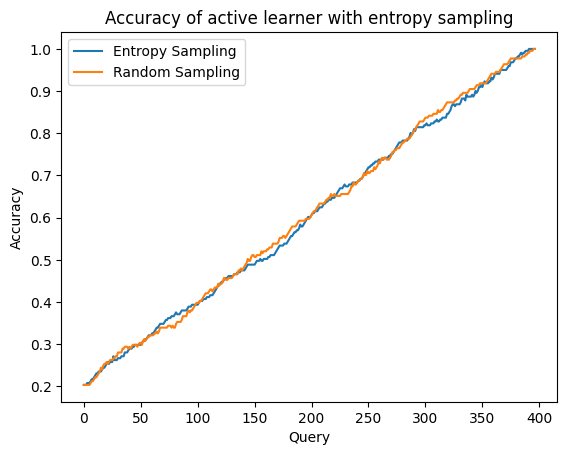

In [4]:
plt.title('Accuracy of active learner with entropy sampling')
plt.xlabel('Query')
plt.ylabel('Accuracy')
plt.plot(range(len(accuracy)),accuracy, label='Entropy Sampling')
plt.plot(range(len(accuracy_rand)),accuracy_rand, label='Random Sampling')
plt.legend()
plt.show()